In [217]:
# Mount to my Google Drive
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/MyDrive/Yale Academic Course Work/Semester Work/Spring 2022 Semester/S&DS 492/Sparse Regression")

Mounted at /content/drive


In [218]:
# Check what GPU we are using
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c21d303a-d6f6-0fbf-31be-178a8c8c8ea6)


In [219]:
import tensorflow as tf
import numpy as np
import pickle
import cvxpy as cvx

In [220]:
# Import our code
from linear_regression_generalization import generate_sparse_dataset, train_linreg_network

# Model Setup

In [221]:
# Dimension of problem
d = 500

# Sparsity of problem 
# There are r nonzero coordinates of the beta vector, and they are the first five coordinates
r = 5
indices = range(5)

In [166]:
# Number of training points
N =  300

In [133]:
# Generate our training dataset
train_data = generate_sparse_dataset(N, d, r, indices=indices, filename=f'training_data_sparse_regression_{N}.pk')

In [84]:
# And our test dataset
num_test = 100
test_data = generate_sparse_dataset(num_test, d, r, indices=indices, filename='test_data_sparse_regression_300.pk')

In [7]:
# Initialization shape and scales for our NN
w0 = tf.ones([2*d, 1])
alphas = list(np.logspace(-2, 0, 20))

In [167]:
# Load in previous data
with open(f'training_data_sparse_regression_{N}.pk', 'rb') as f:
    train_data = pickle.load(f)

with open('test_data_sparse_regression.pk', 'rb') as f:
    test_data = pickle.load(f)

# Model Training

In [168]:
# Code from Woodworth et al. to find the minimum \ell_1 norm solution
X = train_data[0]
y = train_data[1]

beta_0 = cvx.Variable([d,1])
problem = cvx.Problem(cvx.Minimize(cvx.norm(beta_0,1)), [X @ beta_0 == y])
problem.solve(solver = cvx.GLPK_MI)

l1_solution = problem.value
beta_l1 = beta_0.value

In [ ]:
# Now let's train the models
output = train_linreg_network((train_data[0], train_data[1]), (test_data[0], test_data[1]), w0, alphas=alphas, lr=10**(-3))

In [18]:
# Save the output from training
with open(f'sparse_generalization_{N}.pk', 'wb') as f:
        pickle.dump(output, f)

# Visualizing Results

In [21]:
import matplotlib.pyplot as plt

In [19]:
# Import prior outputs
with open('sparse_generalization_100.pk', 'rb') as f:
    output100 = pickle.load(f)

with open('sparse_generalization_300.pk', 'rb') as f:
    output300 = pickle.load(f)

with open('sparse_generalization_500.pk', 'rb') as f:
    output500 = pickle.load(f)

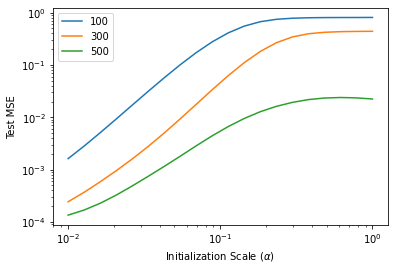

In [222]:
# Now plot the MSE on the test dataset against the initialization scale \alpha for each of the models we trained
fig = plt.figure(0)

plt.plot(alphas, [output100[1][i][-1] for i in range(len(alphas))], label="100")
plt.plot(alphas, [output300[1][i][-1] for i in range(len(alphas))], label="300")
plt.plot(alphas, [output500[1][i][-1] for i in range(len(alphas))], label="500")

plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel(r"Initialization Scale ($\alpha$)")
plt.ylabel("Test MSE")

fig.show()
fig.savefig('visualize_test_MSE_log.png', dpi=300)

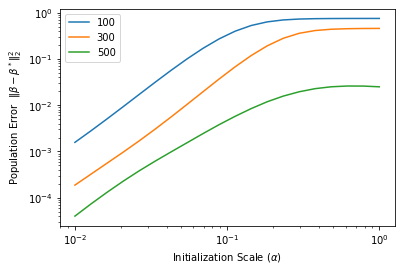

In [227]:
# Rather than looking at the MSE of the model on the test dataset, we can instead consider the \ell_2 distance between the learned and true 
# beta vector, as Woodworth and colleagues do in their paper. This is because, by the Riesz Representation Theorem, the model evaluated at any input x
# is completely detemined by \beta according to the \ell_2 inner product of \beta and x.  
fig = plt.figure(0)

beta_0 = train_data[2]

plt.plot(alphas, [np.linalg.norm((np.square(output100[3][i].numpy())[0:d] - np.square(output100[3][i].numpy())[d:]) - beta_0, ord=2)**2 for i in range(len(alphas))], label="100")
plt.plot(alphas, [np.linalg.norm((np.square(output300[3][i].numpy())[0:d] - np.square(output300[3][i].numpy())[d:]) - beta_0, ord=2)**2 for i in range(len(alphas))], label="300")
plt.plot(alphas, [np.linalg.norm((np.square(output500[3][i].numpy())[0:d] - np.square(output500[3][i].numpy())[d:]) - beta_0, ord=2)**2 for i in range(len(alphas))], label="500")

plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel(r"Initialization Scale ($\alpha$)")
plt.ylabel(r"Population Error  $\Vert \beta - \beta^* \Vert_2^2$")

fig.show()
fig.savefig('population_error_log.png', dpi=300)

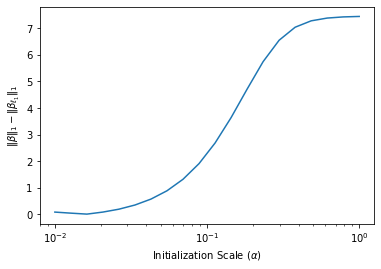

In [228]:
# Plot excess l1 norm of the gradient descent solution, as considered in Woodworth et al. 2020
dist300 = [abs(np.linalg.norm((tf.math.square(i)[0:d] - tf.math.square(i)[d:]), ord=1) - l1_solution) for i in output300[3]]

fig = plt.figure(1)

plt.plot(alphas, dist300)

plt.xscale("log")
#plt.yscale("log")

plt.xlabel(r"Initialization Scale ($\alpha$)")
plt.ylabel(r"$\Vert \beta \Vert_1 - \Vert \beta_{\ell_1}\Vert_1$")
plt.show()
fig.savefig('visualize_exccess_l1.png', dpi=300)

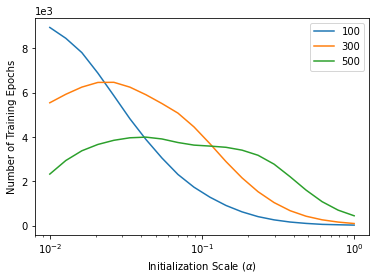

In [148]:
# Plot the number of iterations necessary for gradient descent to converge below 10^(-4),
# our predetmined threshold on the training loss
fig = plt.figure(2)

plt.plot(alphas, output100[2], label="100")
plt.plot(alphas, output300[2], label="300")
plt.plot(alphas, output500[2], label="500")

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xscale("log")
plt.legend()

plt.xlabel(r"Initialization Scale ($\alpha$)")
plt.ylabel("Number of Training Epochs")

fig.show()
fig.savefig('interations_to_convergence.png', dpi=300)

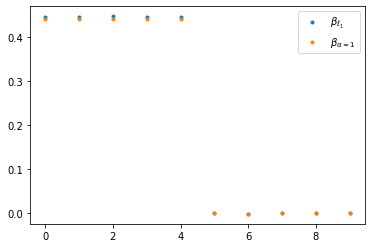

In [175]:
# Plot the first 10 components of the empirical solution vector \beta against the \ell_1 minimum solution vector
fig = plt.figure(3)

plt.plot(beta_l1[0:10], '.', label=r"$\beta_{\ell_1}$")
plt.plot((tf.math.square(output300[3][0])[0:d] - tf.math.square(output300[3][0])[d:])[0:10], '.', label=r"$\beta_{\alpha = 1}$")

plt.legend()
fig.savefig('visualize_solution_vec_0.01.png', dpi=300)